# 2. Experimental data handling
This notebook introduces the functions and datatypes used in `estim8` when working with experimental data. It covers the following the topics:

- creating `Measurement` and `Experiment` objects for custom problems
- obersation mapping
- error modeling

In [1]:
import sys 
sys.path.append(r'..')

from estim8 import visualization, datatypes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# load data 
data = pd.read_excel('SimpleBatch_Data.xlsx', index_col=0, header=(0, 1))
data.head()

Time,X,S
h,g/L,g/L
0.0,0.176200,NaN
0.1,0.318313,NaN
0.2,0.285270,NaN
0.3,0.218600,NaN
0.4,0.248210,NaN


## 3.1 Experiments & Measurements
In `estim8` the data is structured in `Experiment` objects, which consist of individual `Measurement` objects.

In [2]:
# drop multiindex header
data.columns = data.columns.droplevel(1)
exp = datatypes.Experiment(data)
exp.measurements

[Measurement(name=X, replicate_ID=None),
 Measurement(name=S, replicate_ID=None)]

Text(0, 0.5, 'X [g/L]')

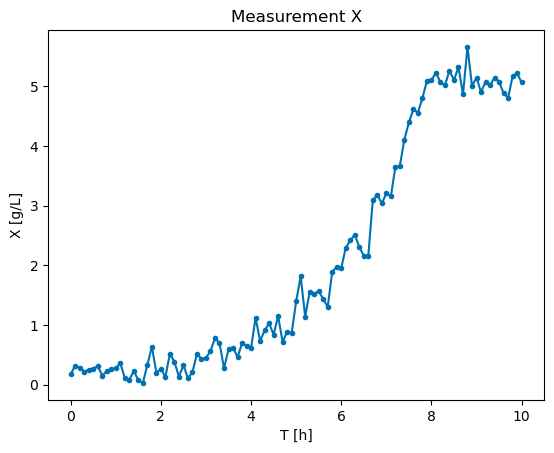

In [3]:
plt.plot( exp['X'].timepoints, exp['X'].values, marker=".")
plt.title('Measurement X')
plt.xlabel('T [h]')
plt.ylabel('X [g/L]')

An `Experiment` can also be created by passing defined `Measurement` objects:

In [4]:
# create measurement objects
measurements = [
    datatypes.Measurement(
        name=column, 
        timepoints=data.index,
        values=data[column].values
    )
    for column in data.columns
]

# create Experiment bbject
exp = datatypes.Experiment(measurements=measurements)

### 3.2 Observation mappings
To map specific measurements to model states with different names, one can define an observation mapping. 

In [5]:
# create a dataframe with different names
df = data.copy()
df.columns= ['obs_X', 'obs_S']
display(df.head())

# define an observation mapping
observation_mapping = {
#   measurement:    model
    'obs_X':        'X',
    'obs_S':        'S'
}

exp = datatypes.Experiment(df, observation_mapping = observation_mapping)

,obs_X,obs_S
0.0,0.176200,NaN
0.1,0.318313,NaN
0.2,0.285270,NaN
0.3,0.218600,NaN
0.4,0.248210,NaN


## 3.3 Error modeling
In objective functions like the _weighted sum of squared residuals_ (WSS) or _negative Log-likelihood_ (negLL) we use the measurement noise $\sigma$ as weights when quantifying model discrepancy. 

### 3.3.1 Linear error model
Per default, `estim8` uses a _linear error model_, which describes the noise as 

$$
\begin{align}
\sigma_i = slope \cdot y_{i_{measured}} + offset
\end{align}
$$

where slope and offset refer to the relative and absolute error respectively. 

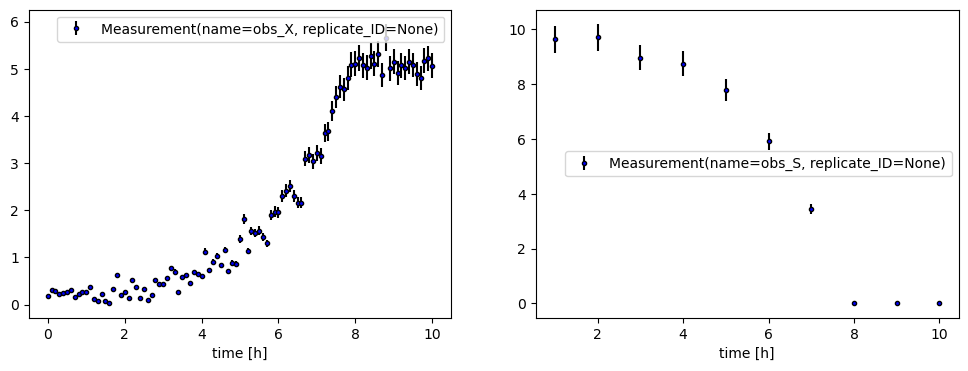

In [6]:
from estim8.error_models import LinearErrorModel

# create a error model instance
my_error_model = LinearErrorModel(slope=0.05, offset=0.01)

# pass the error model to the experiment, which will pass it further to individual measurements
exp = datatypes.Experiment(df, error_model=my_error_model)

# plot measurement with errorbars
fig, axes = plt.subplots(1,2, figsize=(12,4))
for ax, measurement in zip(axes, exp.measurements):
    visualization.plot_measurement(ax=ax, measurement=measurement, color='blue')
    ax.set_xlabel("time [h]")
    ax.legend()

### 3.3.2 Measurement-specific error models

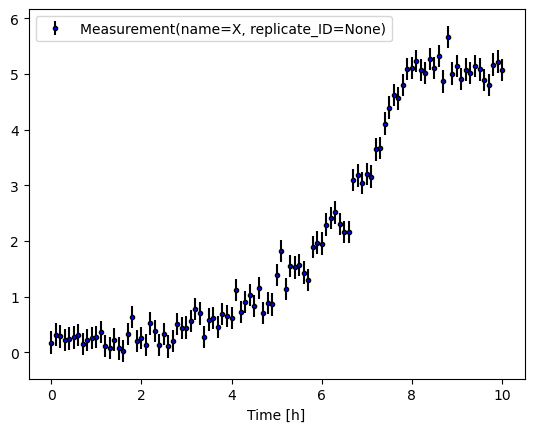

In [7]:
# create an error model instance with an absolute error only e.g. fo a specific measurement
error_model_X = LinearErrorModel(slope=0, offset=0.2)

# create a measurement object with unique error model
measurement_X = datatypes.Measurement(
    name='X',
    timepoints=data.index,
    values=data['X'].values,
    error_model=error_model_X
)

# plot measurement with errorbars
fig, ax = plt.subplots()
_ = visualization.plot_measurement(ax=ax, measurement=measurement_X, color='blue')
ax.set_xlabel('Time [h]')
ax.legend()

Alternatively, one can always provide an array of error values when creating a `Measurement` object.

Text(0.5, 0, 'time [h]')

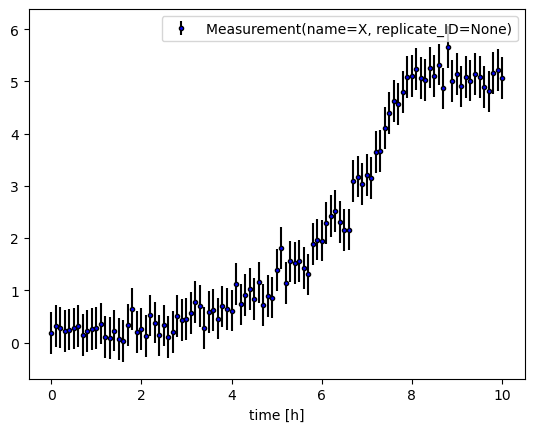

In [8]:
# create an array of error values with same shape as measurement values
errors = np.ones_like(data['X'].values)*0.4

meas = datatypes.Measurement(
    name='X',
    timepoints=data.index,
    values=data['X'].values,
    errors=errors
)

# plot the measurement with errors
_, ax = plt.subplots()
visualization.plot_measurement(ax=ax, measurement=meas, color='blue')
ax.legend()
ax.set_xlabel('time [h]')

### 3.3.3 Custom error models

You can easily implement your own error model class by inheriting from `estim8`'s base class `BaseErrorModel`. The custom class implementation should at least have the class method `generate_error_data`, which recieves a `numpy.ndarray` of datapoints and returns an array of errors. 

Text(0.5, 0, 'time [h]')

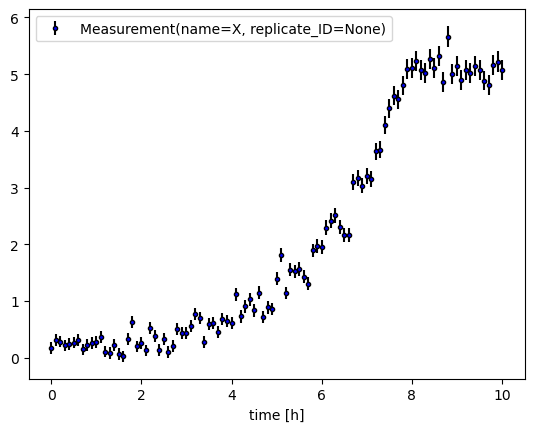

In [9]:
from scipy.stats.distributions import norm, rv_continuous
from estim8.error_models import BaseErrorModel

class PoylnomialErrorModel(BaseErrorModel):

    def __init__(self, a,b,c):
        self.a = a 
        self.b = b
        self.c = c
        super().__init__()
    

    def generate_error_data(self, values: np.array) -> np.array:
        return self.a * values **2 + self.b * values + self.c
    

# create an instance of PolynomialErrorModel
polynomialErrorModel = PoylnomialErrorModel(
    a=1e-3,
    b=1e-2,
    c=1e-1
)

# create a Measurement object, passing the custom error model
meas = datatypes.Measurement(
    name = 'X',
    values = data['X'].values,
    timepoints=data.index,
    error_model=polynomialErrorModel

)

# plot the measurement with errors
_, ax = plt.subplots()
visualization.plot_measurement(ax=ax, measurement=meas, color='blue')
ax.legend()
ax.set_xlabel('time [h]')

### 3.4 Error distributions

Uncertainty quantification techniques like __profile likelihoods__ [(see Notebook 5)](5.%20Parameter%20Identifiability%20-%20Profile%20Likelihood.ipynb) and Monte Carlo sampling [(see Notebook 6)](6.%20Uncertainty%20Quantification%20-%20Monte%20Carlo%20Sampling.ipynb) or calculations of a statistical likelihood require modeling the data via distribution.  

#### 3.4.1 Basics on likelihood and data distribution
For likelihood driven objectives such as the _negLL_ function, the data is described via a
probability distribution. In many cases, we assume data to be _normally_ distributed. Parametrized by mean $\hat{y}$ and standard deviation $\sigma$, the _probability density function_ (PDF) follows

$
\begin{align}
PDF(y)= \frac{1}{\sqrt{2 \pi \sigma^2}} \cdot e^{- \frac{(y-\hat{y})^2}{2 \sigma^2}}
\end{align}
$

Per default, `estim8`'s `ErrorModel` use a normal distribution. For the first datapoint of the biomass measurements `X` from above e.g., we determine the likelihood $p$ of the data $y$ given a model prediction $y_{model}$ by evaluating $pdf(y_{model})$:

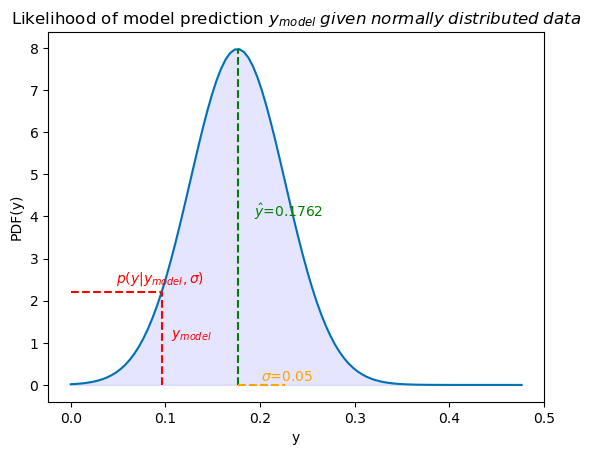

In [10]:
meas = datatypes.Measurement(
    name='X',
    timepoints=data.index,
    values=data['X'].values,
    error_model= LinearErrorModel(slope=0, offset=0.05) # we use an absolute error model with sigma=0.05 for every datapoint
)

# get the first datapoint
y_hat = meas.values[0]
sigma = meas.errors[0]

# create array of some possibl values for y
y_model_range = np.linspace(max(0,y_hat-6*sigma), y_hat+6*sigma, 100)
likelihood_y_model_range = meas.error_model.error_distribution.pdf(x=y_model_range, loc=y_hat, scale=sigma)
# plot the pdf for the y range
plt.plot(y_model_range,likelihood_y_model_range )
plt.fill_between(y_model_range, y1=np.zeros_like(y_model_range), y2=likelihood_y_model_range, alpha=0.1, color='blue')
pdf_y_hat = meas.error_model.error_distribution.pdf(x=y_hat, loc=y_hat, scale=sigma)


# define a "simulated" model prediction for y
y_model = y_hat-1.6*sigma
likelihood_y_model = meas.error_model.error_distribution.pdf(x=y_model, loc=y_hat, scale=sigma)

# plot y_hat
plt.vlines(x=y_hat, ymin=0, ymax=pdf_y_hat, linestyles='dashed', colors='green')
plt.annotate(r"$\hat{y}$="+str(y_hat), xy=(y_hat*1.1, pdf_y_hat/2), color='green')
# plot sigma
plt.hlines(y=0, xmin=y_hat, xmax=y_hat+sigma, linestyles='dashed', color='orange')
plt.annotate(r"$\sigma$="+str(sigma),xy=(y_hat+(sigma/2), 0.1),color='orange')


# plot likelihoood of model prediction
plt.vlines(x=y_model, ymax=likelihood_y_model, ymin=0, color='red', linestyles="dashed")
plt.hlines(y=likelihood_y_model, xmin=min(y_model_range), xmax=y_model, colors='red',linestyles='dashed')
plt.annotate(r'$y_{model}$', xy=(y_model*1.1, likelihood_y_model/2), color='red')
plt.annotate(r"$p(y|y_{model},\sigma)$", xy=(y_model/2, likelihood_y_model*1.1), color='red')

plt.xlabel('y')
plt.ylabel('PDF(y)')
plt.title(r"Likelihood of model prediction $y_{model} \; given \; normally \; distributed \; data$")
fig.tight_layout()

#### 3.4.2 Working with custom error distributions

In order to use different or completely customized error distributions, a __distribution instance__ (a subclass of `scipy.stats.rv_continuous` ) can be passed when creating an error model object. 
For an overview of available continuous distributions, check out the docs of [scipy](https://docs.scipy.org/doc/scipy/reference/stats.html).

In the example below, we use _student t_ distribution, which addiitionally takes a parameter `df` as input:

In [11]:
from scipy.stats import rv_continuous, t

err_model = LinearErrorModel(
    slope=0, 
    offset=0.05,
    error_distribution=t,
    error_distribution_kwargs={'df':10}
)